In this tutorial, we will create boundaries of Finnish hospital districts (sairaanhoitopiiri in Finnish) by dissolving municipality boundaries into larger entities. Main processing steps include a table join and dissolving the municipality geometries into larger entities.

We will combine information from municipality polygons from Statistics Finland and a list of health care districts by the Finnish Municipality authority Kuntaliitto.

Importing required python packages:

In [1]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt

Read in data¶
Municipality polygons from Statistics Finland web feature service: https://www.stat.fi/org/avoindata/paikkatietoaineistot/kuntapohjaiset_tilastointialueet.html

wfs: http://geo.stat.fi/geoserver/tilastointialueet/wfs?

feature: tilastointialueet:kunta1000k (most recent information about municipality polygons)

In [2]:
# For available features, see http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetCapabilities
url = "http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetFeature&typename=tilastointialueet:kunta1000k&outputformat=JSON"
geodata = gpd.read_file(url) #read the url (JSON format) to a geodataframe

In [3]:
geodata.head()

,id,kunta,vuosi,nimi,namn,name,geometry
0,kunta1000k.1,005,2022,Alajärvi,Alajärvi,Alajärvi,"POLYGON ((366787.924 7001300.583, 364487.590 6..."
1,kunta1000k.2,009,2022,Alavieska,Alavieska,Alavieska,"POLYGON ((382543.364 7120022.976, 382899.505 7..."
2,kunta1000k.3,010,2022,Alavus,Alavo,Alavus,"POLYGON ((343298.204 6961570.195, 343831.847 6..."
3,kunta1000k.4,016,2022,Asikkala,Asikkala,Asikkala,"POLYGON ((436139.680 6798279.085, 435714.468 6..."
4,kunta1000k.5,018,2022,Askola,Askola,Askola,"POLYGON ((426631.036 6720528.076, 428821.749 6..."


In [4]:
# Check length (there are 310 municipalities in Finland in 2020)
len(geodata)

309

In [5]:
#select and rename columns
geodata.rename(columns={'kunta':'code'},inplace=True)

#select code,name,and geometry columns from geodata, and replace the existing dataframe
geodata = geodata[['code','name','geometry']]
geodata.head()

,code,name,geometry
0,005,Alajärvi,"POLYGON ((366787.924 7001300.583, 364487.590 6..."
1,009,Alavieska,"POLYGON ((382543.364 7120022.976, 382899.505 7..."
2,010,Alavus,"POLYGON ((343298.204 6961570.195, 343831.847 6..."
3,016,Asikkala,"POLYGON ((436139.680 6798279.085, 435714.468 6..."
4,018,Askola,"POLYGON ((426631.036 6720528.076, 428821.749 6..."


<AxesSubplot:>

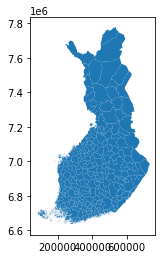

In [6]:
geodata.plot()

In [7]:
geodata.dtypes

code          object
name          object
geometry    geometry
dtype: object

Excel files often come with additional formatting such as metadata on the first lines of the data array. This is why it is a good idea to download the file on your own computer and have a look at the data structure before reading in the file using Python. It is also often a good idea to save the file as a csv file before reading in the data. However, it is also possible to read in data directly from Excel. For this, you need to have the xlrd module installed:

- conda install -c conda-forge xlrd

In the case of this health districts excel the header is located on the 4th row (index 3) of the excel spreadsheet.

In [9]:
data = pd.read_excel(r"Shp_jäsenkunnat_2020.xls", sheet_name="kunnat_shp_2020_ aakkosjärj.", header=3)

In [10]:
print(data.head())

   kunta-\nkoodi      kunta  shp:n koodi  sairaanhoitopiiri erva-alue  \
0            NaN        NaN          NaN                NaN       NaN   
1           20.0       Akaa          6.0          Pirkanmaa      TAYS   
2            5.0   Alajärvi         15.0    Etelä-Pohjanmaa      TAYS   
3            9.0  Alavieska         18.0  Pohjois-Pohjanmaa       OYS   
4           10.0     Alavus         15.0    Etelä-Pohjanmaa      TAYS   

   kuntien lkm  
0          NaN  
1          1.0  
2          2.0  
3          3.0  
4          4.0  


- In addition, the first row after the header is empty. We can get rid of it using the dropna() -function:

In [11]:
data.dropna(inplace=True)

In [12]:
print(len(data))

294


In [14]:
#Rename columns kunta-\nkoodi & 'sairaanhoitopiiri'
data.rename(columns= { 'kunta-\nkoodi': 'code', 'sairaanhoitopiiri':'healthCareDistrict' }, inplace=True)

#select subset useful columns
data = data[['code','healthCareDistrict']]

In [15]:
print(data)

      code healthCareDistrict
1     20.0          Pirkanmaa
2      5.0    Etelä-Pohjanmaa
3      9.0  Pohjois-Pohjanmaa
4     10.0    Etelä-Pohjanmaa
5     16.0        Päijät-Häme
..     ...                ...
290  977.0  Pohjois-Pohjanmaa
291  980.0          Pirkanmaa
292  981.0         Kanta-Häme
293  989.0    Etelä-Pohjanmaa
294  992.0        Keski-Suomi

[294 rows x 2 columns]


In [16]:
print(data.dtypes)

code                  float64
healthCareDistrict     object
dtype: object


- prepare the data for table join. We will use the municipality code as the common key.

- The code column is currently a floating point number. We need to modify these codes so that they match the ones in the spatial data:

In [19]:
# Example using one code
number = data.at[1, "code"]
print(number)

# Conver this number to character string 020
print("20".zfill(3))

20.0
020


-  apply this process on all rows at once, and take into account different number of digits:

In [20]:
#convert each row of code column from into to str
data["code"] = data["code"].astype(int).astype('str')

#add missing zeros to municipality code strings
data["code"] = data["code"].str.zfill(3)

In [21]:
data.head()

,code,healthCareDistrict
1,020,Pirkanmaa
2,005,Etelä-Pohjanmaa
3,009,Pohjois-Pohjanmaa
4,010,Etelä-Pohjanmaa
5,016,Päijät-Häme


Join Health district info to the municipality polygons

In [22]:
#merge health districts into geodata using 'code' as the key, preserve geodata columns and append data columns to geodata
geodata = geodata.merge(data, on="code", how= "left")

In [23]:
geodata

,code,name,geometry,healthCareDistrict
0,005,Alajärvi,"POLYGON ((366787.924 7001300.583, 364487.590 6...",Etelä-Pohjanmaa
1,009,Alavieska,"POLYGON ((382543.364 7120022.976, 382899.505 7...",Pohjois-Pohjanmaa
2,010,Alavus,"POLYGON ((343298.204 6961570.195, 343831.847 6...",Etelä-Pohjanmaa
3,016,Asikkala,"POLYGON ((436139.680 6798279.085, 435714.468 6...",Päijät-Häme
4,018,Askola,"POLYGON ((426631.036 6720528.076, 428821.749 6...",HUS
...,...,...,...,...
304,977,Ylivieska,"POLYGON ((398010.991 7110887.267, 399696.069 7...",Pohjois-Pohjanmaa
305,980,Ylöjärvi,"POLYGON ((313738.511 6896936.100, 319421.316 6...",Pirkanmaa
306,981,Ypäjä,"POLYGON ((297451.456 6756204.328, 297931.884 6...",Kanta-Häme
307,989,Ähtäri,"POLYGON ((348733.187 6959704.551, 349457.337 6...",Etelä-Pohjanmaa


- Check the count of municipalities per health care disctrict

In [38]:
#Municipalities in the Åland island did not have a matching health care district in the data. Let’s have a closer look:
geodata["healthCareDistrict"].value_counts(dropna=False)

Pohjois-Pohjanmaa    29
Varsinais-Suomi      28
HUS                  24
Pirkanmaa            23
Keski-Suomi          21
Etelä-Pohjanmaa      18
Pohjois-Savo         18
NaN                  16
Satakunta            16
Lappi                15
Vaasa                13
Pohjois-Karjala      13
Päijät-Häme          12
Kanta-Häme           11
Keski-Pohjanmaa      10
Etelä-Savo            9
Etelä-Karjala         9
Kainuu                8
Kymenlaakso           6
Länsi-Pohja           6
Itä-Savo              4
Name: healthCareDistrict, dtype: int64

In [39]:
# List all municipalities that lack health district info:
geodata[geodata["healthCareDistrict"].isnull()].name

7          Brändö
8          Eckerö
15       Finström
17          Föglö
18           Geta
24     Hammarland
57         Jomala
111      Kumlinge
121         Kökar
134       Lemland
147    Lumparland
153     Mariehamn
236       Saltvik
254      Sottunga
256          Sund
301         Vårdö
Name: name, dtype: object

In [40]:
# Update "Ahvenanmaa" as the health care district for Åland municipalities (16 municipalities in total)
geodata.loc[geodata["healthCareDistrict"].isnull(), "healthCareDistrict"] = "Ahvenanmaa"

- Check the count of municipalities per health care disctrict

In [41]:
geodata["healthCareDistrict"].value_counts()

Pohjois-Pohjanmaa    29
Varsinais-Suomi      28
HUS                  24
Pirkanmaa            23
Keski-Suomi          21
Etelä-Pohjanmaa      18
Pohjois-Savo         18
Ahvenanmaa           16
Satakunta            16
Lappi                15
Vaasa                13
Pohjois-Karjala      13
Päijät-Häme          12
Kanta-Häme           11
Keski-Pohjanmaa      10
Etelä-Savo            9
Etelä-Karjala         9
Kainuu                8
Kymenlaakso           6
Länsi-Pohja           6
Itä-Savo              4
Name: healthCareDistrict, dtype: int64

In [42]:
#dissolve (aggregate geometries - municipality polygon geometries for each health care district
districts = geodata.dissolve(by= 'healthCareDistrict')

In [43]:
districts.reset_index(inplace=True)

In [44]:
#Select useful columns
districts = districts[["healthCareDistrict", "geometry"]]

In [45]:
districts

,healthCareDistrict,geometry
0,Ahvenanmaa,"MULTIPOLYGON (((73987.240 6697201.016, 73996.4..."
1,Etelä-Karjala,"POLYGON ((532977.917 6741313.207, 529917.560 6..."
2,Etelä-Pohjanmaa,"POLYGON ((267794.597 6906783.873, 267352.980 6..."
3,Etelä-Savo,"POLYGON ((461869.214 6804910.484, 462537.714 6..."
4,HUS,"MULTIPOLYGON (((266121.775 6637948.040, 266071..."
5,Itä-Savo,"POLYGON ((599514.246 6823216.797, 598553.102 6..."
6,Kainuu,"POLYGON ((544756.828 7080852.564, 543902.663 7..."
7,Kanta-Häme,"POLYGON ((296901.865 6736363.869, 295788.771 6..."
8,Keski-Pohjanmaa,"MULTIPOLYGON (((294303.166 7093997.252, 294176..."
9,Keski-Suomi,"POLYGON ((363260.793 6987161.698, 362732.775 6..."


(40857.339215, 765862.479085, 6575077.820610001, 7833703.7515899995)

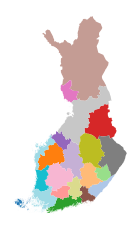

In [47]:
districts.plot(column='healthCareDistrict', cmap='tab20',k=20) #plot a different color for each grid x 20 grids
plt.axis('off')

In [48]:
#Write GeoJSON in original projection
districts.to_file("healthDistrictsEPSG3067.geojson", driver='GeoJSON', encoding= 'utf-8')

C:\Users\aly\AppData\Local\Continuum\anaconda3\envs\python-gis\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [49]:
#reproject to WGS84 and save again
wgs84 = CRS.from_epsg(4326)
districts.to_crs(wgs84).to_file("healthDistrictsEPSG4326.geojson",driver='GeoJSON', encoding='utf-8')

C:\Users\aly\AppData\Local\Continuum\anaconda3\envs\python-gis\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
